# Computational Caricaturization of Surfaces

## This is python implementation of "Computational Caricaturization of Surfaces"

In [1]:
import igl
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import open3d as o3d
import ipywidgets as widgets
from open3d.visualization import draw_plotly

from IPython.display import display
# import plotly.graph_objects as go

import trimesh

import torch
import torch.nn.functional as F

from pytorch3d.utils import ico_sphere
from pytorch3d.structures import Meshes

from easydict import EasyDict
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:


# mesh loading
# V, F = igl.read_triangle_mesh("m02_model_face.obj")
# V, F = igl.read_triangle_mesh("000_neutral.obj")
# V, F = igl.read_triangle_mesh("m02_model.obj")
V, F = igl.read_triangle_mesh("../SMPL_TPose_00.obj")

V = V.astype(np.float64)
F = F.astype(np.int32)

# cotangent & mass matrix
C = igl.cotmatrix(V, F)               # cotangent matrix
# M = igl.massmatrix(V, F, igl.MASSMATRIX_TYPE_VORONOI)

D = igl.doublearea(V, F) * 0.5        # |K| : area of each face
D = np.abs(D)
D = np.hstack([D, D, D])
D_ = sp.diags(D)
    
# GC = igl.gaussian_curvature(V, F)     # shape: (nV,)

# gradient operator
G = igl.grad(V, F)                    # shape: (3*T, nV) ::: T = F.shape[0]

# edge-based operators
L = G.T @ G                           # Approx. Laplacian

# carve out the deformation
def compute_caricature(gamma=0.25):
    # shape difference operator: target exaggeration
    K = np.power(D, gamma)
    # E = int(V.shape[0]/2)
    # E = 6706
    # E = 9409
    # K[:E] = 0
    # K[E:] = 0
    K = sp.diags(K)
    
    # exaggerate shape difference
    b = L @ V                          # nV x 3
    
    A = G.T @ (K @ G)                  # Laplacian approx (nV x nV)
    
    V_new = spla.spsolve(A, b)
    V_new = V_new.reshape(-1,3)
    
    return V_new

def get_new_mesh(V_new):
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(V_new)
    mesh.triangles = o3d.utility.Vector3iVector(F)
    mesh.compute_vertex_normals()
    return mesh

# ipywidgets slider
gamma_slider = widgets.FloatSlider(value=0.2, min=0.0, max=1.0, step=0.05, description='Gamma')
output = widgets.Output()

# update drawing
def update_plot(gamma):
    output.clear_output(wait=True)
    with output:
        if gamma > 0:
            V_new = compute_caricature(gamma)
            m = get_new_mesh(V_new)
            draw_plotly([m],width=600, height=600)
        else:
            m = get_new_mesh(V)
            draw_plotly([m],width=600, height=600)

# ipywidgets interaction
widgets.interact(update_plot, gamma=gamma_slider)
display(output)

interactive(children=(FloatSlider(value=0.2, description='Gamma', max=1.0, step=0.05), Output()), _dom_classes…

Output()

## Save mesh

In [58]:
V_new = compute_caricature(gamma=.2)
igl.write_triangle_mesh("m02_deformed-0.2.obj", V_new, F)

V_new = compute_caricature(gamma=.45)
igl.write_triangle_mesh("m02_deformed-0.45.obj", V_new, F)

True

In [27]:
asd = trimesh.load(r"D:\test\Mesh-editing-with-pyopengl\_tmp\016039.obj",process=False, maintain_order=True)

c:\Users\SihunCha\.conda\envs\pytorch3d\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [31]:
print(asd.vertices.shape, asd.faces.shape)

(7306, 3) (10936, 3)


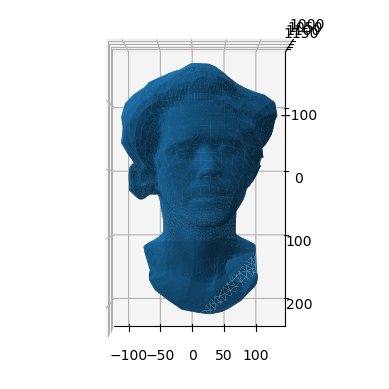

In [ ]:
# asd.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.view_init(azim=-90, elev=-90)
ax.set_box_aspect((np.ptp(asd.vertices[:, 0]),np.ptp(asd.vertices[:, 1]),np.ptp(asd.vertices[:, 2])))
ax.plot_trisurf(asd.vertices[:, 0], asd.vertices[:,1], asd.vertices[:,2], triangles=asd.faces)

In [29]:
qwe = trimesh.load(r"D:\test\Mesh-editing-with-pyopengl\_tmp\test.obj",process=False, maintain_order=True)

In [32]:
print(qwe.vertices.shape, qwe.faces.shape)

(6788, 3) (10936, 3)


In [38]:
asd = load_obj_mesh(r"D:\test\Mesh-editing-with-pyopengl\_tmp\016039.obj")
qwe = load_obj_mesh(r"D:\test\Mesh-editing-with-pyopengl\_tmp\test.obj")

In [41]:
print(asd.v.shape, asd.f.shape)
print(qwe.v.shape, asd.f.shape)

print(asd.vt.shape, asd.ft.shape)
print(qwe.vt.shape, asd.ft.shape)

(7306, 3) (10936, 3)
(6788, 3) (10936, 3)
(32808, 2) (10936, 3)
(6788, 2) (10936, 3)
